<a href="https://colab.research.google.com/github/Hashnroll/stanford_cs231n_2019/blob/master/im_caption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchsummary
from torchvision import transforms, models
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import h5py
import numpy as np
import json
from collections import defaultdict
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import glob
from collections import Counter
import nltk
nltk.download('punkt')

%matplotlib inline

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
cuda


### Загрузка датасета

In [0]:
# !unzip -qq 'drive/My Drive/coco_captioning/annotations_trainval2014.zip'
# !unzip -qq 'drive/My Drive/coco_captioning/train2014.zip'
# !unzip -qq 'drive/My Drive/coco_captioning/val2014.zip'

### Чтение датасета

Создадим кастомный класс для загрузки изображений и их описаний из файлов

In [0]:
tokenizer = nltk.RegexpTokenizer(r"\w+")

class CocoCaptions(torch.utils.data.Dataset):
  def __init__(self, images_folder, annotations_file, vocabulary=None,
                transform=None):
    
    anns = json.load(open(annotations_file, 'r'))
    # словарь image_id -> image file_name
    self.images = dict()
    for img in tqdm(anns['images'], desc='Getting images paths'):
      self.images[img['id']] = images_folder + '/' + img['file_name']

    # словарь ann_id -> аннотация
    self.annotations = defaultdict(list)
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    for ann in anns['annotations']:
      self.annotations[ann['id']] = ann

    self.ids = list(sorted(self.annotations.keys()))
    
    # составить словарь, если не передан как аргумент
    if vocabulary is None:
        self.vocabulary = self.build_vocabulary()
    else:
        self.vocabulary = vocabulary

    self.transform = transform
      
  # составить словарь из 5000 самых частых слов
  def build_vocabulary(self, vocab_size = 5000):
      word_counter = Counter()
      for ann in tqdm(self.annotations.values(), desc = 'Building vocabulary'):
        words = tokenizer.tokenize(ann['caption'].lower())
        word_counter.update(words)
              
      most_frequent_words = [w for (w, c) in word_counter.most_common(vocab_size)]
      word2id = {w: (index + 1) for (index, w) in enumerate(most_frequent_words)}
      
      # добавляем служебные символы
      word2id['<pad>'] = 0 # служебный символ для корректной работы ячейки LSTM
      word2id['<start>'] = len(word2id)
      word2id['<end>'] = len(word2id)
      word2id['<unk>'] = len(word2id) # служебный символ, обозначающий слова, которых нет в словаре
      id2word = {index: w for (w, index) in word2id.items()}
      return {'word2id': word2id, 'id2word': id2word}
  
  # преобразование описания в список идентификаторов
  def caption2ids(self, caption):
      word2id = self.vocabulary['word2id']
      caption_ids = [word2id.get(w, word2id['<unk>']) for w in tokenizer.tokenize(caption.lower())]
      caption_ids.insert(0, word2id['<start>'])
      caption_ids.append(word2id['<end>'])
      return torch.LongTensor(caption_ids)
  
  # преобразование списка идентификаторов в описание
  def ids2caption(self, caption_ids):
      id2word = self.vocabulary['id2word']
      return ' '.join([id2word[w] for w in caption_ids])
  
  # вернуть по индексу изображение и его описание 
  def __getitem__(self, index):
    ann = self.annotations[self.ids[index]]

    image = Image.open(self.images[ann['image_id']]).convert('RGB')
    if self.transform is not None:
      image = self.transform(image)

    return image, self.caption2ids(ann['caption'])

  def __len__(self):
      return len(self.ids)

In [4]:
transform_train = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

train_data = CocoCaptions('train2014', 'annotations/captions_train2014.json',
                         transform=transform_train)
print('Number of training examples: ', len(train_data))


Number of training examples:  414113


In [5]:
transform_val = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_data = CocoCaptions('val2014', 'annotations/captions_val2014.json',
                        vocabulary=train_data.vocabulary, transform=transform_val)
print('Number of validation examples: ', len(val_data))


Number of validation examples:  202654


Определим кастомную функцию для формирования батчей

In [0]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

def pad_collate(data):
  # отсортируем по длине описания
  data.sort(key=lambda x: len(x[1]), reverse=True)
  images, captions = zip(*data)

  # составим 4D тензор изображений из кортежа 3D тензоров (для того, чтобы PyTorch воспринимал)
  # images: (batch_size, channels(rgb), width, height)
  images = torch.stack(images, 0)

  # составим 2D тензор описаний из кортежа 1D тензоров
  # дополним каждое описание символом <pad> так, чтобы у всех описаний совпадали длины
  lengths = [len(cap) for cap in captions]
  targets = torch.zeros(len(captions), max(lengths)).long()
  for i, cap in enumerate(captions):
    end = lengths[i]
    targets[i, :end] = cap[:end]        
  return images, targets, lengths

Определеми даталоадеры для обучения и валидации

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True,
                                          num_workers=4, collate_fn=pad_collate)

val_loader = torch.utils.data.DataLoader(val_data, batch_size=128, shuffle=False,
                                          num_workers=4, collate_fn=pad_collate)

### Определим encoder и decoder

In [0]:
class Encoder(nn.Module):
  def __init__(self, embed_size):
    super().__init__()
    resnet = models.resnet34(pretrained=True)

    # удаляем последний слой, т.к. кол-во его выходных нейронов не подходит для задачи аннотирования
    modules = list(resnet.children())[:-1]
    self.resnet = nn.Sequential(*modules)
    # отключаем обучение у всех слоев
    for param in resnet.parameters():
        param.requires_grad = False
    # определяем новый линейный слой, кол-во выходных нейронов равно размерности эмбеддинга
    self.linear = nn.Linear(resnet.fc.in_features, embed_size)
    # слой нормализации по батчу
    self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

  def forward(self, images):
    with torch.no_grad():
      features = self.resnet(images)
    features = features.reshape(features.size(0), -1)
    features = self.bn(self.linear(features))
    return features

In [0]:
class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1,
                 max_seq_length=20):
      super().__init__()
      self.embedding = nn.Embedding(vocab_size, embed_size)    
      self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
      self.linear = nn.Linear(hidden_size, vocab_size)
      self.max_seg_length = max_seq_length

    # обучение, используются истинные описания
    def forward(self, features, captions, lengths):
      embed = self.embedding(captions)
      embed = torch.cat((features.unsqueeze(1), embed), 1)
      packed = pack_padded_sequence(embed, lengths, batch_first=True)
      hiddens, _ = self.lstm(packed)
      outputs = self.linear(hiddens[0])
      return outputs

    # проверка, истинные описания не используются
    def sample(self, features, states=None):
      sampled_ids = []
      inputs = features.unsqueeze(1)
      for i in range(self.max_seg_length):
        hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
        outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
        _, predicted = outputs.max(1)                        # predicted: (batch_size)
        sampled_ids.append(predicted)
        inputs = self.embedding(predicted)                   # inputs: (batch_size, embed_size)
        inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
      sampled_ids = torch.stack(sampled_ids, 1)              # sampled_ids: (batch_size, max_seq_length)
      return sampled_ids

In [0]:
embed_size = 512
hidden_size = 512

encoder = Encoder(embed_size).to(device)
decoder = Decoder(embed_size, hidden_size, len(train_data.vocabulary['word2id'])).to(device)

criterion = nn.CrossEntropyLoss()

params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params=params, lr=1e-3)

### Обучение

In [11]:
num_epochs = 5
log_step = 100
epoch_losses = defaultdict(list)

for epoch in range(1, num_epochs + 1):
  running_loss = 0.0

  # режим обучения
  encoder.train()
  decoder.train()

  for i, (images, captions, lengths) in enumerate(tqdm(train_loader, 
                                                       desc=f'Epoch {epoch}/{num_epochs}')):
    # Перенесем изобр-я и описания на GPU, составим вектор истинных описаний
    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

    # Проведем изобр-я через CNN-LSTM модель, получим описания (в виде векторов id), сгенерир. моделью
    features = encoder(images)
    outputs = decoder(features, captions, lengths)

    # посчитать лосс на батче
    loss = criterion(outputs, targets)
    
    # посчитать градиенты
    loss.backward()
    
    # обновить параметры модели и обнулить градиенты
    optimizer.step()
    optimizer.zero_grad()

    running_loss += loss.item()

    if i % log_step == 0:
      print(f'Batch {i} loss = {loss.item():.4f}')

  train_loss = running_loss / len(train_loader)
  epoch_losses['train'].append(train_loss)

  print(f'Epoch {epoch} loss = {train_loss:.4f}')

Batch 0 loss = 8.5223
Batch 100 loss = 3.6136
Batch 200 loss = 3.3354
Batch 300 loss = 3.1931
Batch 400 loss = 2.9291
Batch 500 loss = 2.7193
Batch 600 loss = 2.9824
Batch 700 loss = 2.5888
Batch 800 loss = 2.6571
Batch 900 loss = 2.6867
Batch 1000 loss = 2.5891
Batch 1100 loss = 2.5407
Batch 1200 loss = 2.5226
Batch 1300 loss = 2.5968
Batch 1400 loss = 2.5601
Batch 1500 loss = 2.4616
Batch 1600 loss = 2.4870
Batch 1700 loss = 2.4107
Batch 1800 loss = 2.3701
Batch 1900 loss = 2.5600
Batch 2000 loss = 2.2463
Batch 2100 loss = 2.2935
Batch 2200 loss = 2.3052
Batch 2300 loss = 2.3239
Batch 2400 loss = 2.3216
Batch 2500 loss = 2.3075
Batch 2600 loss = 2.3119
Batch 2700 loss = 2.3320
Batch 2800 loss = 2.2174
Batch 2900 loss = 2.4230
Batch 3000 loss = 2.2858
Batch 3100 loss = 2.2759
Batch 3200 loss = 2.3017

Epoch 1 loss = 2.6008


Batch 0 loss = 2.0925
Batch 100 loss = 2.1730
Batch 200 loss = 2.1931
Batch 300 loss = 2.2013
Batch 400 loss = 2.2683
Batch 500 loss = 2.1089
Batch 600 loss = 2.2122
Batch 700 loss = 2.2053
Batch 800 loss = 2.2040
Batch 900 loss = 2.1870
Batch 1000 loss = 2.2578
Batch 1100 loss = 2.0514
Batch 1200 loss = 2.1957
Batch 1300 loss = 2.2076
Batch 1400 loss = 2.1709
Batch 1500 loss = 2.1311
Batch 1600 loss = 2.1845
Batch 1700 loss = 2.2729
Batch 1800 loss = 2.0647
Batch 1900 loss = 2.2266
Batch 2000 loss = 2.1790
Batch 2100 loss = 2.2049
Batch 2200 loss = 2.1694
Batch 2300 loss = 2.1466
Batch 2400 loss = 2.1685
Batch 2500 loss = 2.1212
Batch 2600 loss = 2.1426
Batch 2700 loss = 1.9975
Batch 2800 loss = 2.1773
Batch 2900 loss = 2.1804
Batch 3000 loss = 2.1973
Batch 3100 loss = 2.3444
Batch 3200 loss = 2.1243

Epoch 2 loss = 2.1891


Batch 0 loss = 2.1128
Batch 100 loss = 1.9698
Batch 200 loss = 2.2116
Batch 300 loss = 2.1046
Batch 400 loss = 2.0375
Batch 500 loss = 2.1312
Batch 600 loss = 2.0452
Batch 700 loss = 1.9750
Batch 800 loss = 1.9884
Batch 900 loss = 2.0976
Batch 1000 loss = 2.0333
Batch 1100 loss = 1.9744
Batch 1200 loss = 2.0409
Batch 1300 loss = 2.0110
Batch 1400 loss = 2.0782
Batch 1500 loss = 1.9810
Batch 1600 loss = 1.9866
Batch 1700 loss = 1.9736
Batch 1800 loss = 2.0030
Batch 1900 loss = 1.8901
Batch 2000 loss = 2.0232
Batch 2100 loss = 2.1132
Batch 2200 loss = 2.1661
Batch 2300 loss = 2.1840
Batch 2400 loss = 2.0085
Batch 2500 loss = 2.0389
Batch 2600 loss = 2.0815
Batch 2700 loss = 1.9986
Batch 2800 loss = 2.0724
Batch 2900 loss = 2.0881
Batch 3000 loss = 2.1124
Batch 3100 loss = 1.9860
Batch 3200 loss = 2.0075

Epoch 3 loss = 2.0727


Batch 0 loss = 1.8705
Batch 100 loss = 1.7988
Batch 200 loss = 1.9923
Batch 300 loss = 1.9114
Batch 400 loss = 2.0262
Batch 500 loss = 1.9076
Batch 600 loss = 2.0202
Batch 700 loss = 2.0035
Batch 800 loss = 2.0870
Batch 900 loss = 1.9420
Batch 1000 loss = 1.8751
Batch 1100 loss = 1.9363
Batch 1200 loss = 2.0392
Batch 1300 loss = 1.8930
Batch 1400 loss = 2.0004
Batch 1500 loss = 2.0491
Batch 1600 loss = 1.9993
Batch 1700 loss = 1.8386
Batch 1800 loss = 2.0477
Batch 1900 loss = 2.0767
Batch 2000 loss = 2.0199
Batch 2100 loss = 2.0046
Batch 2200 loss = 1.9350
Batch 2300 loss = 2.0492
Batch 2400 loss = 2.0752
Batch 2500 loss = 1.9759
Batch 2600 loss = 1.9931
Batch 2700 loss = 2.0603
Batch 2800 loss = 2.0330
Batch 2900 loss = 1.9727
Batch 3000 loss = 1.9344
Batch 3100 loss = 2.0099
Batch 3200 loss = 2.0478

Epoch 4 loss = 1.9932


Batch 0 loss = 1.8912
Batch 100 loss = 1.8672
Batch 200 loss = 1.9246
Batch 300 loss = 1.9250
Batch 400 loss = 1.9528
Batch 500 loss = 1.8753
Batch 600 loss = 1.9209
Batch 700 loss = 1.8051
Batch 800 loss = 1.9855
Batch 900 loss = 2.0959
Batch 1000 loss = 1.8486
Batch 1100 loss = 2.0171
Batch 1200 loss = 1.9484
Batch 1300 loss = 1.9430
Batch 1400 loss = 1.8697
Batch 1500 loss = 1.8573
Batch 1600 loss = 1.9318
Batch 1700 loss = 2.0052
Batch 1800 loss = 1.9776
Batch 1900 loss = 1.8875
Batch 2000 loss = 1.9870
Batch 2100 loss = 1.9868
Batch 2200 loss = 2.0059
Batch 2300 loss = 2.0706
Batch 2400 loss = 1.9747
Batch 2500 loss = 1.9079
Batch 2600 loss = 2.0149
Batch 2700 loss = 1.9137
Batch 2800 loss = 1.9741
Batch 2900 loss = 1.7968
Batch 3000 loss = 1.9461
Batch 3100 loss = 1.8950
Batch 3200 loss = 2.0224

Epoch 5 loss = 1.9302


Сохраним веса модели

In [0]:
# torch.save(encoder.state_dict(), f"encoder_weigths.pth")
# torch.save(decoder.state_dict(), f"decoder_weigths.pth")

График функции потерь на обучающей выборке по эпохам

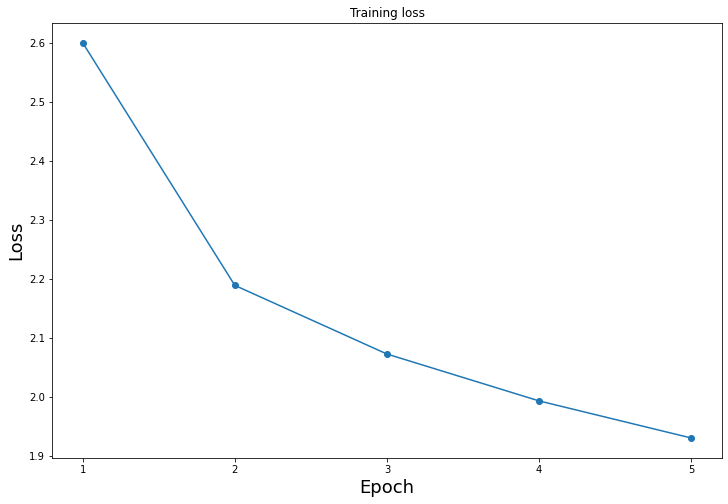

In [26]:
plt.figure(figsize=(12, 8))
plt.title('Training loss')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.xticks(list(range(1, num_epochs + 1)))
plt.plot(list(range(1, num_epochs + 1)), epoch_losses['train'], marker='o')
plt.show()

### Валидация

Посмотрим на результаты модели на случайных изображениях из валидационной выборки

--------------------------------------------------
True caption: A frozen pizza in the oven already cooked
Predicted caption: <start> a pizza with a black pan on top of it <end>


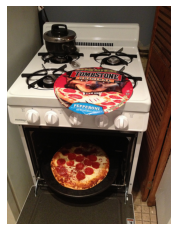

--------------------------------------------------
True caption: some giraffes a building trees rocks dirt and plants
Predicted caption: <start> a giraffe standing next to a tree in a zoo <end>


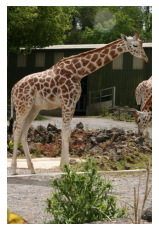

--------------------------------------------------
True caption: two elephants enjoy playing in the cool water
Predicted caption: <start> a baby elephant standing next to a bigger elephant <end>


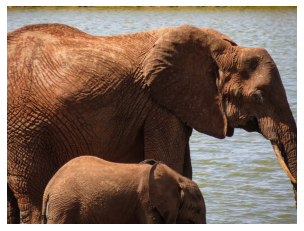

--------------------------------------------------
True caption: a lawn chair on a sidewalk in the snow
Predicted caption: <start> a man is sitting on a bench with a skateboard <end>


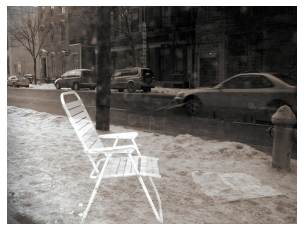

--------------------------------------------------
True caption: A cat sitting next to a beer watching television.
Predicted caption: <start> a cat is sitting on a desk with a computer <end>


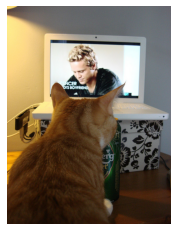

In [33]:
import random

# режим оценки
encoder.eval()
decoder.eval()
with torch.no_grad():
  for index in random.sample(range(len(val_data)), 5):
    ann = val_data.annotations[val_data.ids[index]]
    raw_image = Image.open(val_data.images[ann['image_id']]).convert('RGB')
   
    image, _ = val_data[index]
    image = image.unsqueeze(0).to(device)
    features = encoder(image)
    caption_ids_pred = decoder.sample(features)[0].cpu().numpy()
    caption_pred = ''.join(val_data.ids2caption(caption_ids_pred).partition('<end>')[:-1])
    
    print('-' * 50)
    print(f"True caption: {ann['caption']}")
    print(f"Predicted caption: {caption_pred}")

    plt.imshow(raw_image)
    plt.axis('off')
    plt.show()